Deep Learning
=============

Assignment Sparse Autoencoder
------------

Structured from `2_fullyconnected.ipynb`

The goal of this assignment is to train a sparse autoencoder network on MNIST Data and visulize its validation data reconstruction.

In [16]:
import sys
print(sys.version)


3.5.2 (v3.5.2:4def2a2901a5, Jun 25 2016, 22:18:55) [MSC v.1900 64 bit (AMD64)]


In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import re
import sys
import tensorflow as tf
from six.moves import cPickle as pickle
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import matplotlib.cm as cm
if re.search("ipykernel", sys.argv[0]) :
    %matplotlib inline

First we load the MNIST data

In [2]:
data_set = input_data.read_data_sets('', False)
training_data=data_set.train
testing_data=data_set.test

Extracting train-images-idx3-ubyte.gz
Extracting train-labels-idx1-ubyte.gz
Extracting t10k-images-idx3-ubyte.gz
Extracting t10k-labels-idx1-ubyte.gz


Checking  the data

In [3]:
images_feed, labels_feed = training_data.next_batch(10000,False)
image_size = 28
num_labels=10
np.min(images_feed)

0.0

Do validation testing:
- data as a flat matrix,


In [4]:
validation_data=data_set.validation
valid_batch,validation_labels=validation_data.next_batch(validation_data.num_examples)


In [5]:

validation_data.num_examples

5000

In [17]:
batch_size = 128
nHidden=196
image_size=28
beta=3
rho=.1

graph = tf.Graph()
with graph.as_default() as g:

  with tf.name_scope('ae/'):
      # Input data. For the training data, we use a placeholder that will be fed
      # at run time with a training minibatch.
      tf_train_dataset = tf.placeholder(tf.float32,
                                        shape=(batch_size, image_size * image_size), name='input')
      tf_valid_dataset = tf.constant(valid_batch)
      #tf_test_dataset = tf.constant(test_dataset)
       
      # Variables.
      weights_hidden1 = tf.Variable(tf.truncated_normal([image_size * image_size, nHidden],stddev=0.01), name='hidden0/weights')
      weights = tf.transpose(weights_hidden1, name='hidden1/weights')
      biases_hidden1 = tf.Variable(tf.zeros([nHidden]), name='hidden0/biases')
      biases = tf.Variable(tf.zeros([image_size*image_size]), name='hidden1/biases')
      
      # Training computation.
      hidden_comp=tf.matmul(tf_train_dataset, weights_hidden1)
      hidden1 = tf.nn.sigmoid(hidden_comp  + biases_hidden1, name='hidden0/units')
      output_units = tf.nn.sigmoid(tf.matmul(hidden1, weights) + biases, name='hidden1/units')
      rho = tf.constant(rho, name='rho')
      rho_hat = tf.reduce_mean(output_units, 0)
      # rho_hat = tf.Print(rho_hat, [rho_hat, tf.shape(rho_hat), 'rho_hat'])
      rho_inv = tf.constant(1.) - rho
      # rho_inv = tf.Print(rho_inv, [rho_inv, tf.shape(rho_inv), 'rho_inv'])
      rho_hat_inv = tf.constant(1.) - rho_hat
      # rho_hat_inv = tf.Print(rho_hat_inv, [rho_hat_inv, tf.shape(rho_hat_inv), 'rho_hat_inv'])
      term1 = rho * tf.log(rho / rho_hat)
      # term1 = tf.Print(term1, [term1, tf.shape(term1), 'term1'])
      term2 = rho_inv * tf.log(rho_inv / rho_hat_inv)
      # term2 = tf.Print(term2 , [term2 , tf.shape(term2 ), 'term2 '])
      kl_term = term1 + term2
      # kl_term = tf.Print(kl_term, [kl_term, tf.shape(kl_term), 'kl_term'])
      latent_loss = tf.reduce_sum(kl_term, 0, name='kl_div')
      loss_sub = tf.nn.l2_loss(tf.subtract(output_units, tf_train_dataset))
      loss_sub = tf.Print(loss_sub, [loss_sub, tf.shape(loss_sub), 'l2_loss'])
      loss = tf.reduce_mean(loss_sub, name='loss')+latent_loss#,tf.constant(float(batch_size)))
      tf.summary.scalar('loss', loss)
      # Optimizer.
      optimizer = tf.train.GradientDescentOptimizer(0.001).minimize(loss, name='optimizer')

      # Predictions for the training, validation, and test data.
      valid_output_units=tf.nn.sigmoid(tf.matmul(tf.nn.sigmoid(tf.matmul(tf_valid_dataset, weights_hidden1)  + biases_hidden1),weights)+biases)
      valid_loss= tf.reduce_mean(tf.nn.l2_loss(tf.subtract(valid_output_units, tf_valid_dataset)))#,tf.constant(float(batch_size)))
        #l2_loss variation check
        #adaptive beta
        #sigmoid output

      summary = tf.summary.merge_all()


In [18]:
num_steps = 100000

with tf.Session(graph=graph) as session:
  train_writer = tf.summary.FileWriter('train_summary_ipynb', session.graph)
  tf.initialize_all_variables().run()
  print("Initialized")
  batch_data,_ = training_data.next_batch(batch_size)
  # Prepare a dictionary telling the session where to feed the minibatch.
  # The key of the dictionary is the placeholder node of the graph to be fed,
  # and the value is the numpy array to feed to it.
  feed_dict = {tf_train_dataset : batch_data}
  _, l, v_l, valid_out_data = session.run([optimizer, loss, valid_loss, valid_output_units], feed_dict=feed_dict)
  prev_v_l = v_l
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    # Generate a minibatch.
    batch_data,_ = training_data.next_batch(batch_size)
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data}
    summary_out, _, l, feature_weights, feature_biases= session.run(
      [summary, optimizer, loss, weights_hidden1, biases_hidden1], feed_dict=feed_dict)
    train_writer.add_summary(summary_out, step)
    if step%500==0:
        _, l, v_l, valid_out_data = session.run([optimizer, loss, valid_loss,valid_output_units], feed_dict=feed_dict)
        print("step", step," \tTrain loss ",l, "\tValid loss",v_l)
        if prev_v_l < v_l:
            break
        
# for i in xrange(batch_size):
    #        plt.imshow(features[i].reshape(image_size,image_size), cmap=cm.gray)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
step 0  	Train loss  5419.28 	Valid loss 208540.0
step 500  	Train loss  1413.44 	Valid loss 55941.5


KeyboardInterrupt: 

## Displaying the reconstruction of first 100 input images in validation by trained sparse autoencoder

(784, 196)
(196, 784)


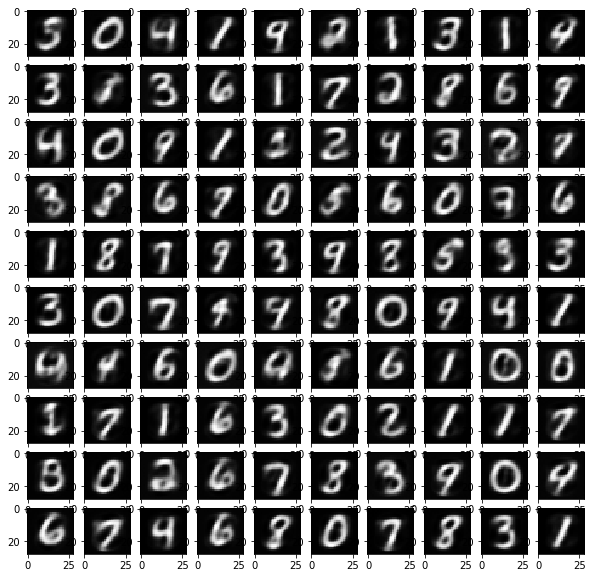

In [13]:
print(feature_weights.shape)
features=feature_weights.transpose()  
print(features.shape)

fig = plt.figure(figsize = (10,10))
for i in range(100):
   ax = fig.add_subplot(10,10,i+1)
   ax.imshow(valid_out_data[i].reshape(image_size,image_size), cmap=cm.gray)

### Displaying the first 100 features used to do the reconstruction

(784, 196)
(196, 784)


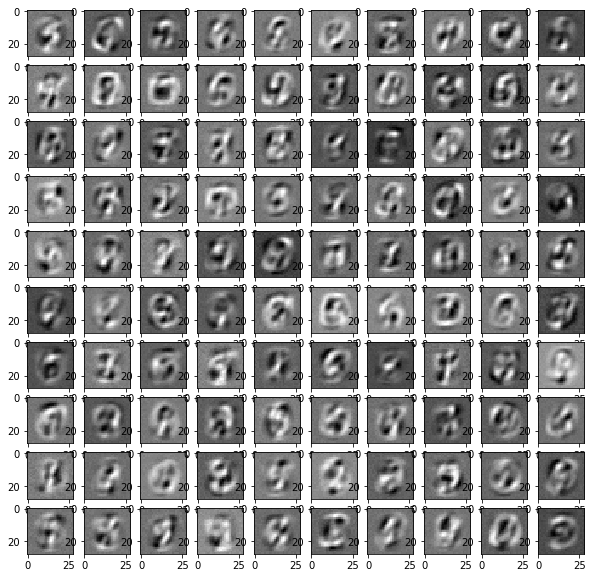

In [14]:
print(feature_weights.shape)
features=feature_weights.transpose()  
print(features.shape)

fig = plt.figure(figsize = (10,10))
for i in range(100):
   ax = fig.add_subplot(10,10,i+1)
   ax.imshow(features[i].reshape(image_size,image_size), cmap=cm.gray)

## Training Softmax Classifier

In [12]:
test_dataset,testing_labels=testing_data.next_batch(testing_data.num_examples)

In [ ]:
batch_size = 128
num_labels=10
nHidden=196
beta=3
rho=.1
tf.reset_default_graph()
graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  weights_hidden1 = tf.constant(feature_weights)
  biases_hidden1 = tf.constant(feature_biases)
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_batch)
  tf_test_dataset = tf.constant(test_dataset)
   
  # Variables.
  logit_weights= tf.Variable(tf.truncated_normal([nHidden, num_labels]))
  logit_biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  hidden1 = tf.nn.sigmoid(tf.mul(tf.matmul(tf_train_dataset, weights_hidden1)  + biases_hidden1,8))
  logits = tf.matmul(hidden1, logit_weights) + logit_biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.001).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(
    tf.nn.sigmoid(tf.matmul(tf_valid_dataset, weights_hidden1) + biases_hidden1), logit_weights) + logit_biases)
  test_prediction = tf.nn.softmax(tf.matmul(
    tf.nn.sigmoid(tf.matmul(tf_test_dataset, weights_hidden1) + biases_hidden1), logit_weights) + logit_biases)

In [14]:
def reformat(labels):
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return labels

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [16]:
num_steps = 100001
valid_labels=reformat(validation_labels)
test_labels=reformat(testing_labels)
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    batch_data,labels= training_data.next_batch(batch_size)
    batch_labels=reformat(labels)
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 4.458472
Minibatch accuracy: 10.2%
Validation accuracy: 10.0%
Minibatch loss at step 500: 4.526332
Minibatch accuracy: 10.2%
Validation accuracy: 9.9%
Minibatch loss at step 1000: 4.072015
Minibatch accuracy: 10.9%
Validation accuracy: 10.0%
Minibatch loss at step 1500: 4.446451
Minibatch accuracy: 10.9%
Validation accuracy: 10.1%
Minibatch loss at step 2000: 4.175397
Minibatch accuracy: 14.8%
Validation accuracy: 10.2%
Minibatch loss at step 2500: 3.968991
Minibatch accuracy: 14.1%
Validation accuracy: 10.4%
Minibatch loss at step 3000: 3.904961
Minibatch accuracy: 14.8%
Validation accuracy: 10.7%
Minibatch loss at step 3500: 3.426284
Minibatch accuracy: 18.8%
Validation accuracy: 10.8%
Minibatch loss at step 4000: 3.833185
Minibatch accuracy: 11.7%
Validation accuracy: 11.0%
Minibatch loss at step 4500: 4.019346
Minibatch accuracy: 18.0%
Validation accuracy: 11.2%
Minibatch loss at step 5000: 3.406018
Minibatch accuracy: 14.8%
Validation accuracy

In [2]:
import pickle

In [22]:
fwf = open('feature_weights.pkl', 'wb')
pickle.dump(feature_weights,fwf,2)

In [24]:
fbf = open('feature_baises.pkl', 'wb')
pickle.dump(feature_biases,fbf,2)

In [3]:
feature_weights=pickle.load(open("feature_weights.pkl", "rb"))

In [9]:
pickle.dump?